# Plotting sea ice in the Southern Ocean
This script produces plots of sea ice area around the Southern Ocean using outputs from ACCESS-OM2-01.  
**Requirements:** It is suggested you use the `conda/analysis3-20.01` (or later) kernel. This can be defined using the drop down list on the left hand corner, or type `!module load conda/analysis3` in a Python cell.

## Loading relevant modules
These modules are used to access relevant outputs and to manipulate data. 

In [1]:
#This first line will show plots produced by matplotlib inside this Jupyter notebook
%matplotlib inline

import cosima_cookbook as cc
import matplotlib.pyplot as plt
import netCDF4 as nc
import xarray as xr
import numpy as np
import pandas as pd
import datetime as dt
import calendar
import os
from dask.distributed import Client, progress

The following modules are used in map creation.

In [2]:
import cmocean as cm                              # Nice colormaps
import cartopy.crs as ccrs                        # For making maps with different projections
import cartopy.feature as cft                     # For adding features to maps

## Accessing model outputs
Start a cluster that has multiple cores to work with. Remember that the number of cores cannot exceed the number of CPUs requested when accessing GADI.  
If the line below does not run, skip it. The result is that the job will not be parallelised, but the script will still run.

In [3]:
client = Client(n_workers = 12)
client

Client Scheduler: tcp://127.0.0.1:46281 Dashboard: /proxy/8787/status,Cluster Workers: 12 Cores: 12 Memory: 51.54 GB


Access the default database of experiments from where data will be loaded.

In [4]:
session = cc.database.create_session()

This notebook uses the outputs for the v140 run of ACCESS-OM2-01 which includes wind forcing. Includes experiments `01deg_jra55v140_iaf` and `01deg_jra55v140_iaf_cycle2`. A list of experiments can be accessed using `cc.querying.get_experiments(session)`, you can get a detailed list of experiments by adding `all = True` argument.

## Accessing ACCESS-OM2 model outputs
Once the correct experiment variables have been identified, data can be loaded into the notebook for further processing.  
The `aice` variable gives the mean concentration of sea ice in a cell (or pixel). The values for this variable are given as proportions.

In [5]:
#Saving name of experiments of interest in variables that can be easily referred to
exp = "01deg_jra55v140_iaf_cycle2"
#Name (short name) of variable of interest
varInt = "aice" #sea ice concentration

Setting date range for the analysis. Note that because times linked to `CICE` outputs require a correction. See the function below for more information.  
Start and end date ranges are given in two different variables: `stime` and `etime` respectively. This is done to make it easy to divide data array into years for the analysis.  

In [6]:
#Give the start and end dates for the analyses. The input must be given as a list, even if it is one item only.
#Dates can be given as full date (e.g., 2010-01-01), just year and month, or just year. If multiple years are to be analysed, ensure both variables have the same length
#Start date
stime = [str(i)+'-02-15' for i in range(2000, 2019, 1)]
#End date
etime = [str(i)+'-02-14' for i in range(2001, 2020, 1)]

#Define frequency. Remember to check frequency and variable of interest are related to each other, for example, aice_m has a monthly frequency, while aice has a daily frequency.
freq = '1 daily'

## Defining functions

### Accessing ACCESS-OM2-01 outputs 
Defining function that loads data automatically using `cc.querying.getvar()` in a loop. The inputs needed are similar to those for the `cc.querying.getvar()` function, with the addition of inputs to define an area of interest.  
The `getACCESSdata` will achieve the following:  
- Access data for the experiment and variable of interest at the frequency requested and within the time frame specified  
- Apply **time corrections** as midnight (00:00:00) is interpreted differently by the CICE model and the xarray package.
    - CICE reads *2010-01-01 00:00:00* as the start of 2010-01-01, while xarray interprets it as the start of the following day (2010-01-02). To fix this problem, 12 hours are subtracted from the time dimension (also known as *time coordinate*).  
- Latitude and longitude will be corrected in the dataset using the `geolon_t` dataset. The coordinate names are replaced by names that are more intuitive.  
- Minimum and maximum latitudes and longitudes can be specified in the function to access specific areas of the dataset if required. 
By default, the longitudes are set to show the **Southern Ocean**, which is defined as ocean waters south of 45S.

In [7]:
#Accessing corrected longitude data to update geographical coordinates in the array of interest
geolon_t = cc.querying.getvar(exp, 'geolon_t', session, n = -1)

#Frequency, experiment and session do not need to be specified if they were defined in the previous step
def getACCESSdata(var, start, end, exp = exp, freq = freq, ses = session, minlat = geolon_t.xt_ocean.values.min(), maxlat = geolon_t.xt_ocean.values.max(),\
                  minlon = -90, maxlon = -45):
    #Accessing data
    vararray = cc.querying.getvar(exp, var, ses, frequency = freq, start_time = start, end_time = end)
    #Applying time correction 
    vararray['time'] = vararray.time - dt.timedelta(hours = 12)
    # assign new coordinates to SST dataset 
    #.coords extracts the values of the coordinate specified in the brackets
    vararray.coords['ni'] = geolon_t['xt_ocean'].values
    vararray.coords['nj'] = geolon_t['yt_ocean'].values
    #Rename function from xarray uses dictionaries to change names. Keys refer to current names and values are the desired names
    vararray = vararray.rename(({'ni':'xt_ocean', 'nj':'yt_ocean'}))
    #Subsetting data to area of interest
    #Subsetting sea ice concentration array
    vararray = vararray.sel(yt_ocean = slice(minlon, maxlon)).sel(xt_ocean = slice(minlat, maxlat))
    return vararray

### Sea ice seasonality calculations
The `SeaIceAdvArrays` function below was losely based on the `calc_ice_season` function from the `aceecostats` R package developed by Michael Sumner at AAD. This function calculates annual sea ice advance, retreat and total sea ice season duration as defined by Massom et al 2013 [DOI:10.1371/journal.pone.0064756].  
Briefly, if sea ice concentration in any pixel is at least 15% over five consecutive days, sea ice is considered to be *advancing*. Sea ice is *retreating* when its concentration is below 15% in any pixel until the end of the sea ice year. Sea ice *season duration* is the period between day of advance and retreat. **Sea ice year is between February 15 and February 14 the following year.**  
The `SeaIceAdvArrays` function needs three inputs:
- `array` which is the data array on which sea ice seasonality calculations will be performed.
- `thres` refers to the minimum sea ice concentration threshold. The default is set to 0.15.
- `ndays` is the minimum amount of consecutive days sea ice must be above threshold to be classified as advancing. Default set to 5.  
  
This function will return (if variables are provided) and save (as netcdf files) three data arrays representing sea ice advance, sea ice retreat and sea ice season duration.

In [200]:
def SeaIceAdvArrays(array, thres = 0.15, ndays = 5):
    '''
    array is the data array on which sea ice seasonality calculations will be performed
    thres refers to the minimum sea ice concentration threshold. The default is set to 0.15
    ndays is the minimum amount of consecutive days sea ice must be above threshold to be classified as advancing. Default set to 5
    
    Function saves three data arrays as netcdf files: advance, retreat and season duration. Data arrays are also given as outputs.
    '''
    
    #Extracting maximum and minimum year information to extract data for the sea ice year 
    MinY = min(array.indexes['time'].to_datetimeindex().year)
    MaxY = max(array.indexes['time'].to_datetimeindex().year)
    
    #Selecting data between Feb 15 to Feb 14 (sea ice year)
    array = array.sel(time = slice(str(MinY)+'-02-15', str(MaxY)+'-02-14'))
    
    ########
    #Preparing masks to perform calculations on areas of interest only
    #Calculate timesteps in dataset (365 or 366 depending on whether it was a leap year or not)
    timesteps = len(array.time.values)

    #Identify pixels (or cells) where sea ice concentration values are equal or above the threshold
    #Resulting data array is boolean. If condition is met then pixel is set to True, otherwise set to False
    threshold = xr.where(array >= thres, True, False)

    #Creating masks based on time over threshold
    #Add values through time to get total of days with ice cover of at least 15% within a pixel
    rsum = threshold.sum('time')

    #Boolean data arrays for masking
    #If the total sum is zero, then set pixel to be True, otherwise set to False. 
    #This identifies pixels where minimum sea ice concentration was never reached.
    noIce = xr.where(rsum == 0, True, False)
    #If the total sum is less than the minimum days, then set pixel to be True, otherwise set to False. 
    #This identifies pixels where sea ice coverage did not meet the minimum consecutive days requirement.
    noIceAdv = xr.where(rsum < ndays, True, False)
    #If the total sum is the same as the timesteps, then set pixel to be True, otherwise set to False.
    #This identifies pixels where sea ice concentration was always at least 15%
    alwaysIce = xr.where(rsum == timesteps, True, False)
    #Remove unused variables
    del rsum

    ########
    #Sea ice advance calculations
    #Use cumulative sums based on time. If pixel has sea ice cover below threshold, then cumulative sum is reset to zero
    adv = threshold.cumsum(dim = 'time')-threshold.cumsum(dim = 'time').where(threshold.values == 0).ffill(dim = 'time').fillna(0)
    #Note: ffill adds nan values forward over a specific dimension

    #Find timestep (date) where the minimum consecutive sea ice concentration was first detected for each pixel
    #Change all pixels that do not meet the minimum consecutive sea ice concentration to False. Otherwise maintain their value.
    advDate = xr.where(adv == ndays, adv, False)
    #Find the time step index where condition above was met.
    advDate = advDate.argmax(dim = 'time')
    #Apply masks of no sea ice advance and sea ice always present.
    advDate = advDate.where(noIceAdv == False, np.nan).where(alwaysIce == False, 1)
    #Remove unused variables
    del adv

    ########
    #Sea ice retreat calculations
    #Reverse threshold data array (time wise) - So end date is now the start date and calculate cumulative sum over time
    ret = threshold[::-1].cumsum('time')
    del threshold
    #Change zero values to 9999 so they are ignored in the next step of our calculation
    ret = xr.where(ret == 0, 9999, ret)
    #Find the time step index where sea ice concentration change to above threshold.
    retDate = ret.argmin(dim = 'time')
    #Substract index from total time length
    retDate = timesteps-retDate
    #Apply masks of no sea ice over threshold and sea ice always over threshold.
    retDate = retDate.where(noIce == False, np.nan).where(alwaysIce == False, timesteps)
    #Remove unused variables
    del ret
    
    ########
    #Sea ice duration
    durDays = retDate-advDate
    
    ########
    #Saving files to disk as netcdf
    advDate.to_netcdf(os.path.join('/g/data/v45/la6889/Calculations/SeaIceSeasonality' , ('SeaIceAdv_' + str(MinY) + '-' + str(MaxY) + '.nc')))
    retDate.to_netcdf(os.path.join('/g/data/v45/la6889/Calculations/SeaIceSeasonality' , ('SeaIceRet_' + str(MinY) + '-' + str(MaxY) + '.nc')))
    durDays.to_netcdf(os.path.join('/g/data/v45/la6889/Calculations/SeaIceSeasonality' , ('SeaIceDur_' + str(MinY) + '-' + str(MaxY) + '.nc')))
    
    return (advDate, retDate, durDays)

### Sea ice seasonality plots
The `SeaIceAdvMap` function plots sea ice advance, retreat and season duration in one panel.  
The `SeaIceAdvMap` function needs the inputs:
- `adv` which is a two dimensional data array containing sea ice advance information. Output 1 from `SeaIceAdvArrays` function.
- `ret` which is a two dimensional data array containing sea ice retreat information. Output 2 from `SeaIceAdvArrays` function.
- `dur` which is a two dimensional data array containing sea ice season duration. Output 3 from `SeaIceAdvArrays` function.
- `minYear` is the start year of the sea ice season
- `maxYear` is the end year of the sea ice season  
  
Optional inputs `**colPal` include:
- `palette` which defines the colour palette to be used. If Scientific Colour Maps by Crameri (2018) are to be used, it expects a string as an input (e.g., palette = 'oslo'), otherwise it expects a matplotlib colormap (e.g., palette = cm.cm.ice).  
  
This function will save a composite figure (png format) with sea ice advance, retreat and season duration.

In [199]:
def SeaIceAdvMap(adv, ret, dur, minYear, maxYear, **colPal):
    '''
    array is the data array on which sea ice seasonality calculations will be performed
    Additional arguments include: palette
    '''
    
    #######################################################
    #Colormap settings
    #Calling libraries to edit long and lat labels
    import matplotlib.ticker as mticker
    from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
    import matplotlib.gridspec as gridspec
    
    #Check if the 'palette' argument has been defined
    if 'palette' in colPal.keys():
        #If the 'palette' argument is a string
        if isinstance(colPal.get('palette'), str):
            #Defining colour palette from Scientific Colour Maps
            #Load relevant libraries to set Scientific Colour Map library
            from matplotlib.colors import LinearSegmentedColormap
            from matplotlib.colors import ListedColormap
            #Set path where the scientific library is found
            cm_data = np.loadtxt(os.path.join('../../ScientificColourMaps6', colPal['palette'], (colPal['palette'] + '.txt')))
            #Create a colour map based on 'palette' argument
            pal_map_adv = LinearSegmentedColormap.from_list(colPal['palette'], cm_data)
            pal_map_ret = ListedColormap(cm_data[::-1])
        #If the 'palette' argument is NOT a string
        elif not isinstance(colPal.get('palette'), str):
            #Load the colour palette defined in the 'palette' argument
            pal_map_adv = colPal['palette']
            pal_map_ret = colPal['palette'][::-1]
    #If 'palette' argument has not been defined, then use cmocean ice palette as default
    else:
        pal_map_adv = cm.cm.ice
        pal_map_ret = cm.cm.ice[::-1]
        
    #Nan values will show as light grey
    pal_map_adv.set_bad(color = '#e0e0e0', alpha = 0.3)
    pal_map_ret.set_bad(color = '#e0e0e0', alpha = 0.3)
    
    ####################################################### 
    #Calculate timesteps in dataset
    if calendar.isleap(int(minYear)) == True:
        timesteps = 366
    else:
        timesteps = 365
    
    #######################################################
    #Plotting maps
    #Change global font and font size
    plt.rcParams['font.family'] = 'serif'
    plt.rcParams['font.size'] = 14
    
    #Extracting maximum and minimum year information to add to plot titles
    MinY = str(minYear)
    MaxY = str(maxYear)
        
    #Define projection to polar
    projection = ccrs.SouthPolarStereo()

    #Create variable containing the Antarctic continent - 50m is medium scale
    land_50m = cft.NaturalEarthFeature('physical', 'land', '50m', edgecolor = 'black', facecolor = 'gray', linewidth = 0.5)
    
    #Define the contour lines to be shown in the graph. From 1 to length of timesteps+1 and increasing by 1
    levels = np.arange(1, timesteps+1, 10)

    #Colourbar tick labels
    cbar_ticks = [int(i) for i in np.arange(5, timesteps+1, 20)]
     
    ########
    #Create composite figure using a grid
    #Top left panel shows sea ice advance, top right panel shows sea ice retreat and bottom panel shows sea ice season duration
    fig = plt.figure(figsize = (17, 15))
    #Create a grid layout to place all subplots in one figure - 4x4 grid created to center bottom plot
    gs = gridspec.GridSpec(nrows = 4, ncols = 4)
     
    ########
    #Plot advancing sea ice day
    #Add subplot in the first two rows and first two columns, so it is aligned to the top left
    ax_adv = fig.add_subplot(gs[:2, :2], projection = projection)
    #Add contour plot of sea ice advance
    p_adv = adv.plot.pcolormesh(x = 'xt_ocean', y = 'yt_ocean', ax = ax_adv,
                  #Setting color palette and contour levels
                  add_colorbar = False, levels = levels, cmap = pal_map_adv, 
                  #Remove colourbar to allow for further manipulation
                  transform = ccrs.PlateCarree())
    #Add subplot title
    ax_adv.set_title('Sea Ice Advance', y = 1.01)
    
    ########
    #Plot retreating sea ice day
    #Add subplot along the first two rows and the last two columns, so it is aligned to the top right
    ax_ret = fig.add_subplot(gs[:2, 2:], projection = projection)
    p_ret = ret.plot.pcolormesh(x = 'xt_ocean', y = 'yt_ocean', ax = ax_ret,
                  #Setting color palette and contour levels
                  cmap = pal_map_ret, levels = levels, add_colorbar = False,
                  #Remove colourbar to allow for further manipulation
                  transform = ccrs.PlateCarree())
    #Add subplot title
    ax_ret.set_title('Sea Ice Retreat', y = 1.01)
    
    ######    
    #Plot sea ice duration
    #Add subplot along the last two rows and in the middle two columns (1 and 2)
    ax_dur = fig.add_subplot(gs[2:4, 1:3], projection = projection)
    #Add contour plot of season duration
    p_dur = dur.plot.pcolormesh(x = 'xt_ocean', y = 'yt_ocean', ax = ax_dur, 
                  #Setting color palette and contour levels
                  cmap = pal_map_ret, levels = levels, add_colorbar = False,
                  #Remove colourbar to allow for further manipulation
                  transform = ccrs.PlateCarree())
    #Add subplot title
    ax_dur.set_title('Sea Ice Season Duration', y = 1.01)
    #Ensure the same aspect is mantained
    ax_dur.set_aspect('equal')
     
    ########
    #Changing colourbars
    #Sea ice advance
    cb_adv = fig.colorbar(p_adv, ax = ax_adv)
    #Set title for colourbar
    cb_adv.ax.set_ylabel('Day of advance')
    
    #Sea ice retreat
    cb_ret = fig.colorbar(p_ret, ax = ax_ret)
    #Set title for colourbar
    cb_ret.ax.set_ylabel('Day of retreat')
     
    #Sea ice season duration
    cb_dur = fig.colorbar(p_dur, ax = ax_dur)
    #Set title for colourbar
    cb_dur.ax.set_ylabel('Duration of sea ice season')
    
    #Setting colourbar ticks and labels
    for cb in [cb_adv, cb_ret, cb_dur]:
        cb.set_ticks(cbar_ticks)
        cb.set_ticklabels(cbar_ticks)

    ########
    #Changing other plot parameters
    for ax in [ax_dur, ax_adv, ax_ret]:
        #Remove x and y axes labels
        ax.set_ylabel("")
        ax.set_xlabel("")
        #Coastlines to appear
        ax.coastlines(resolution = '50m')
        #Add feature loaded at the beginning of this section
        ax.add_feature(land_50m)
        #Set the extent of maps
        ax.set_extent([-280, 80, -80, -50], crs = ccrs.PlateCarree())
        #Adding gridlines gridlines - Removing any labels inside the map on the y axis
        gl = ax.gridlines(draw_labels = True, y_inline = False, color = "#b4b4b4", alpha = 0.6)
        #Locate longitude ticks - Set to every 30 deg
        gl.xlocator = mticker.FixedLocator(np.arange(-180, 181, 30))
        #Give longitude labels the correct format for longitudes
        gl.xformatter = LONGITUDE_FORMATTER
        #Set rotation of longitude labels to zero
        gl.xlabel_style = {'rotation': 0}
        #Set latitude labels to be transparent
        gl.ylabel_style = {'alpha': 0}
        #Add space between axis ticks and labels for x and y axes
        gl.xpadding = 8
        gl.ypadding = 8
        gl.xlabels_left = False
        gl.ylabels_right = False
        gl.xlabels_right = False
        gl.xlabels_top = False
        gl.xlabels_bottom = True
        #Only include labels on the left side of the subplot if it is not the sea ice retreat subplot
        if ax != ax_ret:
            gl.ylabels_left = True
        elif ax == ax_ret:
            gl.ylabels_left = False

    #Set title for composite figure. Move the title along the y axis so it is not too far from 
    fig.suptitle('Sea ice seasonality between February 15, ' + str(MinY) + ' and February 14, '+ str(MaxY), y = 0.925, fontsize = 16)

    #Automatically saving figures to local folder
    plt.savefig(os.path.join('/g/data/v45/la6889/Figures/Maps/SeaIceSeasonality', ('MapSeaIceSeasonal' + str(MinY) + '-' + str(MaxY) + '.png')), dpi = 300)

## Applying functions

### Accessing sea ice concentration data

### Sea ice season calculations and plots
Looping through each year in data array and applying the sea ice season calculations and plotting functions.  
**Note:** If sea ice season calculations have already been saved to disk through the `SeaIceAdvArrays` function, the netcdf files can be loaded as: `adv = xr.open_dataarray('filepath/filename.nc')`. The `SeaIceAdvMap` can then be run using the uploaded files as inputs.

In [ ]:
for i in np.arange(0, len(stime)):
    SO = getACCESSdata(varInt, stime[i], etime[i], freq = freq)
    minYear = stime[i].split('-')[0]
    maxYear = etime[i].split('-')[0]
    adv, ret, sea = SeaIceAdvArrays(SO)
    SeaIceAdvMap(adv, ret, sea, minYear, maxYear, palette = 'batlow')

distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Restarting worker


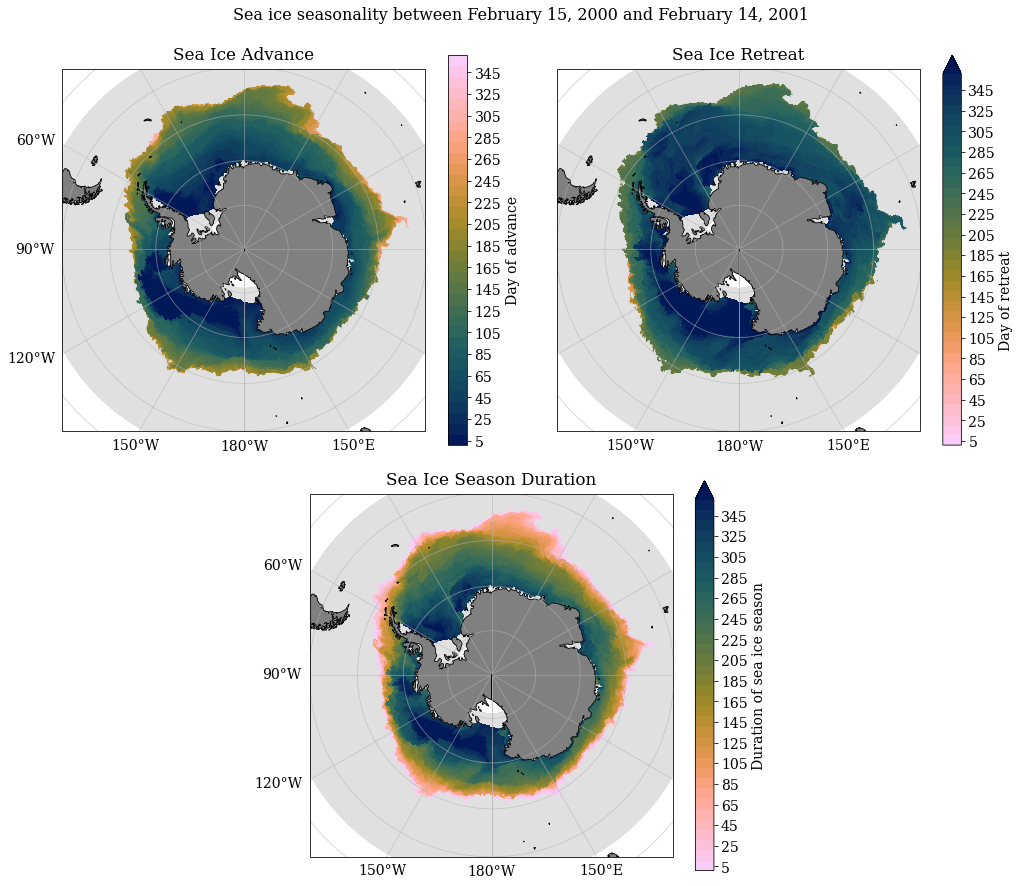

In [196]:
SeaIceAdvMap(adv, ret, sea, minYear, maxYear, palette = 'batlow')